In [ ]:
#!pip install pyramid

In [ ]:
#!pip install pmdarima

# **Séries Temporais - E-commerce**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import scipy as scp
import pmdarima as pmd


## Conhecendo o Dataset

In [46]:
#lendo o dataset, excluindo linhas com erro de leitura e preparando para análise de séries temporais
dados = pd.read_csv('data.csv', encoding='ISO-8859-1')
#parse_dates=True, index_col='InvoiceDate',

In [47]:
#visualizando os dados
dados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [48]:
#vendo quantas invoices possuímos no período
dados.InvoiceNo.nunique()

25900

In [49]:
#vendo quantos clientes temos no dataset
dados.CustomerID.nunique()

4372

In [50]:
#quantos países
dados.Country.nunique()

38

In [51]:
#quantos produtos
dados.Description.nunique()

4223

In [74]:
dados.StockCode.nunique()

4070

In [52]:
#quais países
dados.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

## Tamanho do Dataset

In [53]:
dados.shape

(541909, 8)

In [54]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Dados Faltantes

In [68]:
dados.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Convertendo a InvoiceDate para datetime

In [71]:
#alterando a coluna para datetime
dados.InvoiceDate = pd.to_datetime(dados.InvoiceDate)

## Convertendo tipos

In [34]:
dados.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country'],
      dtype='object')

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 820160 entries, 12/1/2010 8:26 to 12/9/2011 12:50
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    820160 non-null  string
 1   StockCode    820159 non-null  string
 2   Description  818209 non-null  string
 3   Quantity     820153 non-null  object
 4   UnitPrice    820150 non-null  object
 5   CustomerID   625547 non-null  object
 6   Country      820140 non-null  string
dtypes: object(3), string(4)
memory usage: 70.1+ MB


## Primeiro Plot

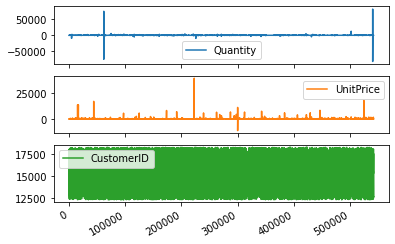

In [56]:
dados.plot(subplots=True);

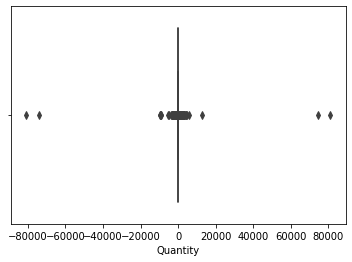

In [60]:
sns.boxplot(x=dados.Quantity);

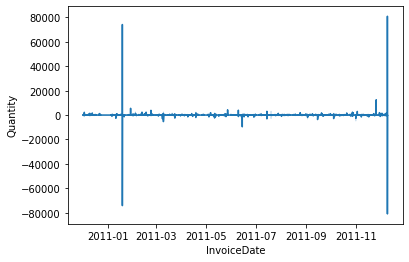

In [72]:
sns.lineplot(x='InvoiceDate', y='Quantity', data=dados)

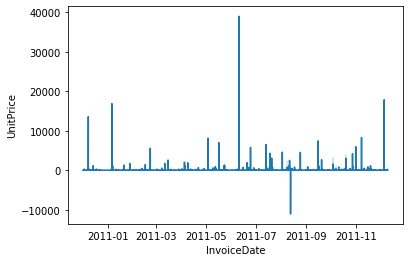

In [73]:
sns.lineplot(x='InvoiceDate', y='UnitPrice', data=dados);

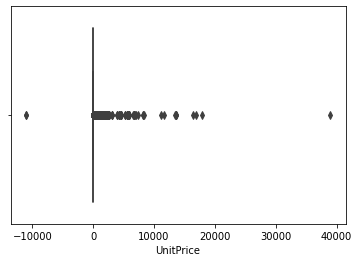

In [61]:
sns.boxplot(x=dados.UnitPrice);

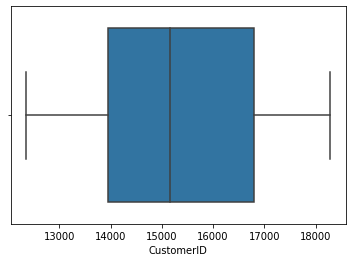

In [67]:
#boxplot de dados que não devem ser tratados como numéricos - só para mostrar o conceito
sns.boxplot(x=dados.CustomerID);

In [63]:
dados.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Buscar Faturas canceladas

In [77]:
#criando uma coluna que informa se o campo InvoiceNo começa com C ou não
dados['CancelledInvoice'] = dados.InvoiceNo.str.startswith('C')

In [79]:
dados['CancelledInvoice'].unique()

array([False,  True])

In [81]:
#localizar as linhas em que o valor dessa coluna criada seja True
canceladas = dados.query('CancelledInvoice == True')

In [82]:
efetivas = dados.query('CancelledInvoice == False')

In [83]:
efetivas.shape

(532621, 9)

In [84]:
canceladas.shape

(9288, 9)

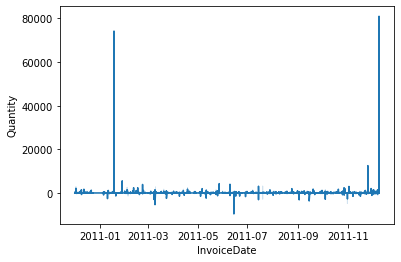

In [85]:
sns.lineplot(x='InvoiceDate', y='Quantity', data=efetivas);

In [86]:
canceladas.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True


In [95]:
efetivas.Quantity.describe()

count    532621.000000
mean         10.239972
std         159.593551
min       -9600.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [109]:
negativas = efetivas.query('Quantity < 0')

In [110]:
negativas.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,False
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,False
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,False
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,False
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,False


In [111]:
negativas.shape

(1336, 9)

In [112]:
negativas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336 entries, 2406 to 538919
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   InvoiceNo         1336 non-null   object        
 1   StockCode         1336 non-null   object        
 2   Description       474 non-null    object        
 3   Quantity          1336 non-null   int64         
 4   InvoiceDate       1336 non-null   datetime64[ns]
 5   UnitPrice         1336 non-null   float64       
 6   CustomerID        0 non-null      float64       
 7   Country           1336 non-null   object        
 8   CancelledInvoice  1336 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 95.2+ KB


## Excluindo quantidades negativas do Dataset

In [113]:
vendas = efetivas.query('Quantity >= 0')

In [114]:
vendas.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False


In [115]:
vendas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531285 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         531285 non-null  object        
 1   StockCode         531285 non-null  object        
 2   Description       530693 non-null  object        
 3   Quantity          531285 non-null  int64         
 4   InvoiceDate       531285 non-null  datetime64[ns]
 5   UnitPrice         531285 non-null  float64       
 6   CustomerID        397924 non-null  float64       
 7   Country           531285 non-null  object        
 8   CancelledInvoice  531285 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.0+ MB


In [117]:
vendas.loc[dados.InvoiceNo.str.startswith('A')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,False
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,False
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,False


In [119]:
vendas.drop(index=[299982,299983,299984], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [120]:
vendas.loc[dados.InvoiceNo.str.startswith('A')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice


In [121]:
vendas.describe()

,Quantity,UnitPrice,CustomerID
count,531282.000000,531282.000000,397924.000000
mean,10.655317,3.878140,15294.315171
std,156.830764,32.510663,1713.169877
min,1.000000,0.000000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [126]:
vendas.query('UnitPrice == UnitPrice.max()')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,False


In [127]:
vendas.drop(index=15017, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [129]:
vendas[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,531281.000000,531281.000000
mean,10.655335,3.852659
std,156.830911,26.683311
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,8142.750000


In [137]:
vendas.loc[dados.StockCode == 'AMAZONFEE']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice


In [131]:
#excluindo a linha acima do dataset
vendas.drop(index=135534, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


InvoiceNo                        539607
StockCode                         21240
Description           BLUE POLKADOT CUP
Quantity                              8
InvoiceDate         2010-12-20 14:10:00
UnitPrice                          0.85
CustomerID                        12681
Country                          France
CancelledInvoice                  False
Name: 38970, dtype: object

In [134]:
vendas.query('UnitPrice == UnitPrice.max()')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,False


In [136]:
vendas.query('StockCode == "POST"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France,False
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662.0,Germany,False
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.0,12738.0,Germany,False
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686.0,France,False
...,...,...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,2011-12-09 10:10:00,15.0,12423.0,Belgium,False
541216,581494,POST,POSTAGE,2,2011-12-09 10:13:00,18.0,12518.0,Germany,False
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.0,12662.0,Germany,False
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.0,12526.0,Germany,False


In [138]:
vendas.StockCode.unique()

array(['85123A', '71053', '84406B', ..., '90214U', '47591b', '23843'],
      dtype=object)

In [139]:
vendas.Description.unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'LETTER "U" BLING KEY RING',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [140]:
vendas_clean = vendas.query('StockCode != "POST"')

In [141]:
vendas_clean[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,530150.000000,530150.000000
mean,10.665804,3.794459
std,156.981011,24.184923
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,11.000000,4.130000
max,80995.000000,4505.170000


In [142]:
# Quantidades acima de 10000
vendas_clean.loc[vendas_clean.Quantity >= 10000] 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,False
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False


In [147]:
#vendo se o cliente que comprou a maior quantidade é reincidente
vendas_clean.loc[vendas_clean.CustomerID == 16446.0] 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,False
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,False
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False


In [148]:
vendas_clean.loc[vendas_clean.CustomerID == 13256.0] 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,False


In [149]:
vendas_clean.loc[vendas_clean.CustomerID == 12346.0] 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False


In [150]:
commerce = vendas_clean.loc[vendas_clean.Quantity <= 10000] 

In [152]:
commerce[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,530147.000000,530147.000000
mean,10.349443,3.794475
std,39.869289,24.184990
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,11.000000,4.130000
max,5568.000000,4505.170000


## Usando Força Bruta para achar outliers

In [155]:
from sklearn.ensemble import IsolationForest

In [157]:
clf = IsolationForest( n_estimators=100, max_samples='auto', 
                       contamination=0.01, 
                       max_features=1.0, 
                       bootstrap=False, 
                       n_jobs=-1, 
                       random_state=42, 
                       verbose=0 )

In [159]:
clf.fit(commerce[['Quantity', 'UnitPrice']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

In [160]:
commerce['Outlier'] = clf.predict(commerce[['Quantity', 'UnitPrice']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [161]:
commerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1


In [162]:
commerce.Outlier.unique()

array([ 1, -1])

In [165]:
outliers = commerce.query('Outlier == -1')

In [166]:
outliers

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029.0,United Kingdom,False,-1
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,False,-1
180,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,False,-1
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029.0,United Kingdom,False,-1
182,536387,21731,RED TOADSTOOL LED NIGHT LIGHT,432,2010-12-01 09:58:00,1.25,16029.0,United Kingdom,False,-1
...,...,...,...,...,...,...,...,...,...,...
541290,581497,22423,REGENCY CAKESTAND 3 TIER,8,2011-12-09 10:23:00,24.96,NaN,United Kingdom,False,-1
541459,581498,22838,3 TIER CAKE TIN RED AND CREAM,1,2011-12-09 10:26:00,29.17,NaN,United Kingdom,False,-1
541540,581498,DOT,DOTCOM POSTAGE,1,2011-12-09 10:26:00,1714.17,NaN,United Kingdom,False,-1
541545,581501,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,180,2011-12-09 10:46:00,0.19,12985.0,United Kingdom,False,-1


In [164]:
commerce.loc[commerce.StockCode == 'DOT']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom,False,-1
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,NaN,United Kingdom,False,-1
5450,536862,DOT,DOTCOM POSTAGE,1,2010-12-03 11:13:00,254.43,NaN,United Kingdom,False,-1
5545,536864,DOT,DOTCOM POSTAGE,1,2010-12-03 11:27:00,121.06,NaN,United Kingdom,False,-1
5685,536865,DOT,DOTCOM POSTAGE,1,2010-12-03 11:28:00,498.47,NaN,United Kingdom,False,-1
...,...,...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,NaN,United Kingdom,False,-1
537254,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,NaN,United Kingdom,False,-1
539368,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,NaN,United Kingdom,False,-1
540908,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,NaN,United Kingdom,False,-1


In [169]:
#vendo tipo de produto que caiu como outlier
outliers.StockCode.nunique()

1062

In [171]:
outliers.Description.unique()

array(['CHILLI LIGHTS', 'LIGHT GARLAND BUTTERFILES PINK',
       'WOODEN OWLS LIGHT GARLAND ', ..., 'RUSTIC MIRROR WITH LACE HEART',
       'HAIRCLIPS FORTIES FABRIC ASSORTED', 'HOME SWEET HOME BLACKBOARD'],
      dtype=object)

In [172]:
#excluindo as postagens do dataset
commerce_1 = commerce.loc[commerce.StockCode != 'DOT']

In [173]:
commerce_1.loc[commerce_1.Outlier == -1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029.0,United Kingdom,False,-1
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,False,-1
180,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,False,-1
181,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029.0,United Kingdom,False,-1
182,536387,21731,RED TOADSTOOL LED NIGHT LIGHT,432,2010-12-01 09:58:00,1.25,16029.0,United Kingdom,False,-1
...,...,...,...,...,...,...,...,...,...,...
540425,581485,20749,ASSORTED COLOUR MINI CASES,84,2011-12-09 09:38:00,6.35,17389.0,United Kingdom,False,-1
541290,581497,22423,REGENCY CAKESTAND 3 TIER,8,2011-12-09 10:23:00,24.96,NaN,United Kingdom,False,-1
541459,581498,22838,3 TIER CAKE TIN RED AND CREAM,1,2011-12-09 10:26:00,29.17,NaN,United Kingdom,False,-1
541545,581501,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,180,2011-12-09 10:46:00,0.19,12985.0,United Kingdom,False,-1


In [184]:
#Usando Match para localizar Códigos de estoque que começam com letras
codigo_string = commerce_1.loc[dados.StockCode.str.match(pat='^\D')]

In [186]:
codigo_string.StockCode.value_counts()

M               327
C2              142
DCGSSGIRL        13
BANK CHARGES     12
DCGSSBOY         11
gift_0001_20     10
gift_0001_10      9
gift_0001_30      8
gift_0001_50      4
PADS              4
DCGS0003          4
gift_0001_40      3
DCGS0076          2
S                 2
DCGS0004          1
DCGS0070          1
m                 1
DCGS0069          1
Name: StockCode, dtype: int64

In [189]:
#Visualizando as observações buscadas com nossa expressão regular, uma a uma
commerce_1.loc[commerce_1.StockCode == 'C2']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,False,-1
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,False,-1
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,False,-1
19975,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.0,13369.0,United Kingdom,False,-1
20016,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.0,14932.0,Channel Islands,False,-1
...,...,...,...,...,...,...,...,...,...,...
515000,579768,C2,CARRIAGE,1,2011-11-30 15:08:00,50.0,14911.0,EIRE,False,-1
516484,579910,C2,CARRIAGE,1,2011-12-01 08:52:00,50.0,14911.0,EIRE,False,-1
518854,580124,C2,CARRIAGE,1,2011-12-01 17:12:00,50.0,NaN,EIRE,False,-1
518905,580127,C2,CARRIAGE,1,2011-12-01 17:51:00,50.0,14911.0,EIRE,False,-1


In [195]:
commerce_1.loc[commerce_1.StockCode == 'S']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
152709,549684,S,SAMPLES,1,2011-04-11 13:24:00,30.00,NaN,United Kingdom,False,-1
419666,572849,S,SAMPLES,1,2011-10-26 12:20:00,33.05,NaN,United Kingdom,False,-1


In [196]:
commerce_1.loc[commerce_1.StockCode == 'm']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
40383,539736,m,Manual,1,2010-12-21 15:18:00,2.55,NaN,United Kingdom,False,1


In [197]:
commerce_1.loc[commerce_1.StockCode == 'M']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,False,1
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,False,1
5684,536865,M,Manual,1,2010-12-03 11:28:00,2.55,NaN,United Kingdom,False,1
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723.0,United Kingdom,False,1
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062.0,United Kingdom,False,1
...,...,...,...,...,...,...,...,...,...,...
526015,580645,M,Manual,1,2011-12-05 13:11:00,219.50,17857.0,United Kingdom,False,-1
526018,580646,M,Manual,800,2011-12-05 13:13:00,0.25,17857.0,United Kingdom,False,-1
530876,580884,M,Manual,1,2011-12-06 12:21:00,0.85,15907.0,United Kingdom,False,1
531432,580956,M,Manual,4,2011-12-06 14:23:00,1.25,17841.0,United Kingdom,False,1


In [199]:
commerce_1.loc[commerce_1.StockCode == 'BANK CHARGES']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
4406,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.000,15823.0,United Kingdom,False,1
62508,541505,BANK CHARGES,Bank Charges,1,2011-01-18 15:58:00,15.000,15939.0,United Kingdom,False,1
152966,549717,BANK CHARGES,Bank Charges,1,2011-04-11 14:56:00,15.000,14606.0,United Kingdom,False,1
175275,551945,BANK CHARGES,Bank Charges,1,2011-05-05 11:09:00,15.000,16714.0,United Kingdom,False,1
327921,565735,BANK CHARGES,Bank Charges,1,2011-09-06 12:25:00,15.000,16904.0,United Kingdom,False,1
361740,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,15.000,13405.0,United Kingdom,False,1
361741,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405.0,United Kingdom,False,1
407618,571900,BANK CHARGES,Bank Charges,1,2011-10-19 14:26:00,15.000,13263.0,United Kingdom,False,1
431351,573586,BANK CHARGES,Bank Charges,1,2011-10-31 14:48:00,15.000,14704.0,United Kingdom,False,1
440745,574546,BANK CHARGES,Bank Charges,1,2011-11-04 14:59:00,15.000,13651.0,United Kingdom,False,1


In [200]:
excluir = ['M', 'm', 'BANK CHARGES', 'C2', 'S']

In [204]:
data = commerce_1.loc[~commerce_1.StockCode.isin(excluir)]

In [206]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1


In [209]:
data_1 = data.query('UnitPrice != 0')

In [210]:
data_1.describe()

,Quantity,UnitPrice,CustomerID,Outlier
count,527790.000000,527790.000000,396338.00000,527790.000000
mean,10.272885,3.266471,15301.69364,0.983994
std,37.732245,4.380821,1709.95439,0.178204
min,1.000000,0.001000,12347.00000,-1.000000
25%,1.000000,1.250000,13975.00000,1.000000
50%,3.000000,2.080000,15159.00000,1.000000
75%,11.000000,4.130000,16803.00000,1.000000
max,4800.000000,649.500000,18287.00000,1.000000


In [222]:
data_1['Total'] = data.Quantity * data.UnitPrice

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [223]:
data_1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,1,20.34


In [224]:
data_1['CustomerID'] = str(data_1['CustomerID'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [225]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527790 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         527790 non-null  object        
 1   StockCode         527790 non-null  object        
 2   Description       527790 non-null  object        
 3   Quantity          527790 non-null  int64         
 4   InvoiceDate       527790 non-null  datetime64[ns]
 5   UnitPrice         527790 non-null  float64       
 6   CustomerID        527790 non-null  object        
 7   Country           527790 non-null  object        
 8   CancelledInvoice  527790 non-null  bool          
 9   Outlier           527790 non-null  int64         
 10  Total             527790 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 44.8+ MB


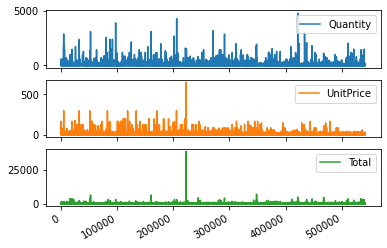

In [226]:
data_1[['Quantity', 'UnitPrice', 'Total']].plot(subplots=True);

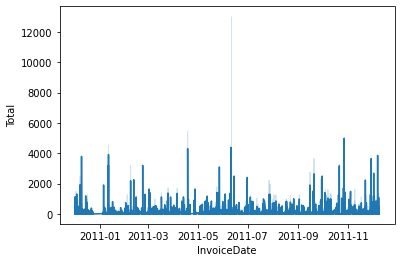

In [227]:
sns.lineplot(x='InvoiceDate', y='Total', data=data_1)

In [230]:
#criando uma coluna só com as datas
data_1["Date"] = [d.date() for d in data_1["InvoiceDate"]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [231]:
data_1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledInvoice,Outlier,Total,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,0 17850.0\n1 17850.0\n2 ...,United Kingdom,False,1,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,0 17850.0\n1 17850.0\n2 ...,United Kingdom,False,1,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,0 17850.0\n1 17850.0\n2 ...,United Kingdom,False,1,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,0 17850.0\n1 17850.0\n2 ...,United Kingdom,False,1,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,0 17850.0\n1 17850.0\n2 ...,United Kingdom,False,1,20.34,2010-12-01


In [232]:
data_1.shape

(527790, 12)

## Agrupando por Data

In [233]:
# df.groupby(['Name', 'Fruit'])['Number'].sum()
totais = data_1.groupby(by='Date')['Total'].sum()

In [235]:
total = pd.DataFrame(totais)

In [236]:
total.head()

,Total
Date,
2010-12-01,57626.33
2010-12-02,47715.38
2010-12-03,44833.98
2010-12-05,31318.99
2010-12-06,51873.43


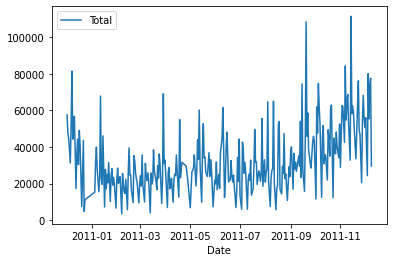

In [238]:
total.plot();

## Visualizando Aumento e Aceleração das Vendas

In [239]:
total['Aumento'] = total['Total'].diff()

In [240]:
total['Aceleração'] = total['Aumento'].diff()

In [241]:
total.head()

,Total,Aumento,Aceleração
Date,,,
2010-12-01,57626.33,NaN,NaN
2010-12-02,47715.38,-9910.95,NaN
2010-12-03,44833.98,-2881.40,7029.55
2010-12-05,31318.99,-13514.99,-10633.59
2010-12-06,51873.43,20554.44,34069.43


In [244]:
total.shape

(305, 3)

In [260]:
#criando uma função de plot comparativo
def plot_comparacao(x, y1, y2,y3, dataset,titulo):
  plt.figure(figsize=(10,8))
  ax = plt.subplot(3,1,1) #3 linhas, um gráfico por linha
  ax.set_title(titulo, fontsize=18, loc='left')
  sns.lineplot(x=x, y=y1, data = dataset)
  plt.subplot(3,1,2)
  sns.lineplot(x=x, y=y2, data = dataset)
  plt.subplot(3,1,3)
  sns.lineplot(x=x, y=y3, data = dataset)
  ax=ax

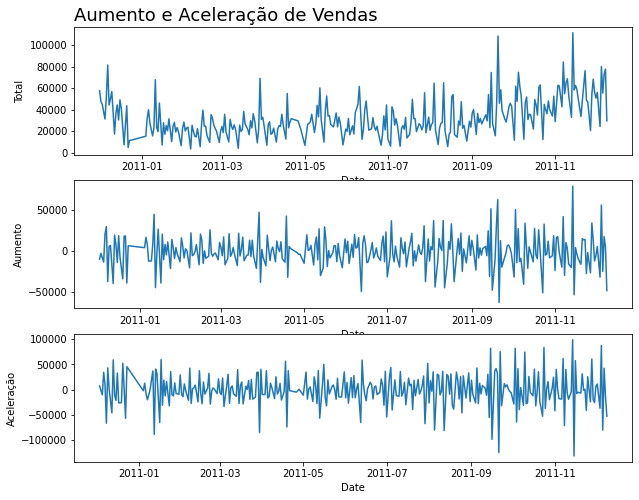

In [261]:
plot_comparacao('Date', 'Total', 'Aumento', 'Aceleração', total, 'Aumento e Aceleração de Vendas')

## Aplicando Média Móvel


In [254]:
#calculada através da função rolling.mean
#calculando a média de 5 em 5 pontos
media_movel_5 = pd.DataFrame(total['Total'].rolling(5).mean())
media_movel_7 = pd.DataFrame(total['Total'].rolling(7).mean())
media_movel_21 = pd.DataFrame(total['Total'].rolling(21).mean())


In [251]:
total

,Total,Aumento,Aceleração
Date,,,
2010-12-01,57626.33,NaN,NaN
2010-12-02,47715.38,-9910.95,NaN
2010-12-03,44833.98,-2881.40,7029.55
2010-12-05,31318.99,-13514.99,-10633.59
2010-12-06,51873.43,20554.44,34069.43
...,...,...,...
2011-12-05,80132.35,55744.92,87462.25
2011-12-06,55411.69,-24720.66,-80465.58
2011-12-07,72922.70,17511.01,42231.67


In [249]:
media_movel.sample(10)

,Total
Date,
2011-08-16,25488.106
2011-08-14,29324.602
2011-09-07,30680.772
2011-05-12,36685.332
2011-04-01,35986.000
2011-06-28,20095.224
2011-04-12,19632.164
2011-06-15,36747.766
2011-05-18,33264.264


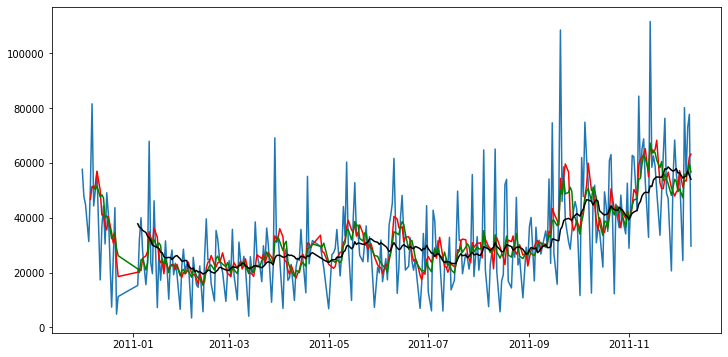

In [257]:
plt.figure(figsize=(12,6))
#gráfico original
plt.plot(total.index, total['Total'])
#gráfico com a média móvel 5 aplicada
plt.plot(media_movel_5.index, media_movel_5['Total'], 'r')
#gráfico com a média móvel 7 aplicada
plt.plot(media_movel_7.index, media_movel_7['Total'], 'g')
#gráfico com a média móvel 21 aplicada
plt.plot(media_movel_21.index, media_movel_21['Total'], 'k')
plt.show()

In [263]:
#CRIANDO uma coluna para a média de vendas
total['Media_Diaria'] = data_1.groupby(by='Date')['Total'].mean()

In [264]:
total.head()

,Total,Aumento,Aceleração,Media_Diaria
Date,,,,
2010-12-01,57626.33,NaN,NaN,18.807549
2010-12-02,47715.38,-9910.95,NaN,23.151567
2010-12-03,44833.98,-2881.40,7029.55,20.950458
2010-12-05,31318.99,-13514.99,-10633.59,11.616836
2010-12-06,51873.43,20554.44,34069.43,13.632965


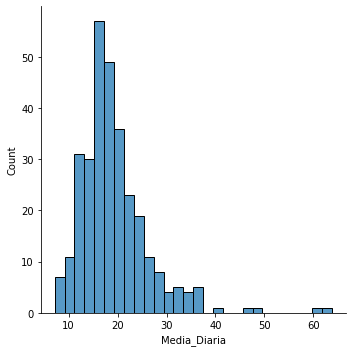

In [324]:
#Verificando a distribuição da média diária
sns.displot(x=total['Media_Diaria']);

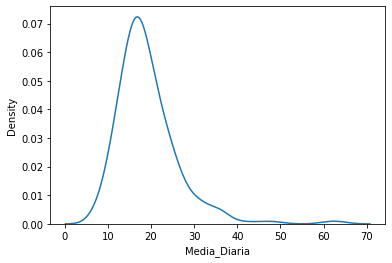

In [268]:
sns.kdeplot(x=total['Media_Diaria']);

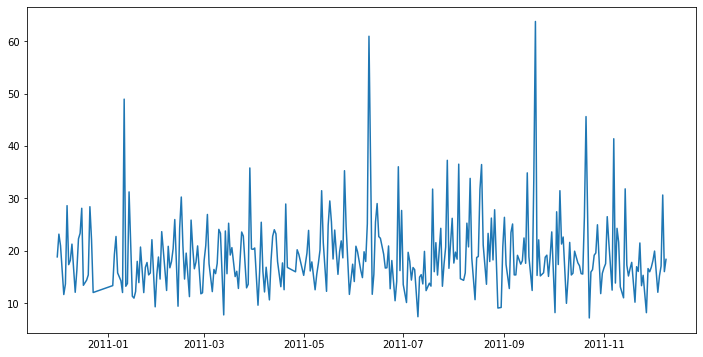

In [270]:
plt.figure(figsize=(12,6))
#gráfico do Ticket Médio de vendas por dia
plt.plot(total.index, total['Media_Diaria']);

In [272]:
#criando as médias Móveis do Ticket_Médio
#calculada através da função rolling.mean
media_movel_5_m = pd.DataFrame(total['Media_Diaria'].rolling(5).mean())
media_movel_7_m = pd.DataFrame(total['Media_Diaria'].rolling(7).mean())
media_movel_21_m = pd.DataFrame(total['Media_Diaria'].rolling(21).mean())

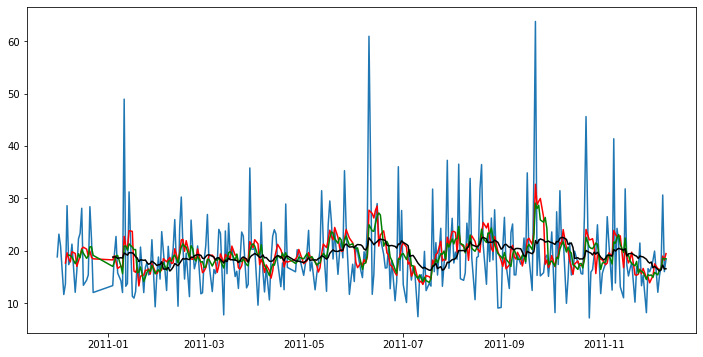

In [273]:
#Plotando com Médias Móveis para o Ticket Médio
plt.figure(figsize=(12,6))
#gráfico original
plt.plot(total.index, total['Media_Diaria'])
#gráfico com a média móvel 5 aplicada
plt.plot(media_movel_5_m.index, media_movel_5_m['Media_Diaria'], 'r')
#gráfico com a média móvel 7 aplicada
plt.plot(media_movel_7_m.index, media_movel_7_m['Media_Diaria'], 'g')
#gráfico com a média móvel 21 aplicada
plt.plot(media_movel_21_m.index, media_movel_21_m['Media_Diaria'], 'k')
plt.show()

In [274]:
#somando as quantidades por dia
total['Quantidade'] = data_1.groupby(by='Date')['Quantity'].sum()
#criando uma coluna com a quantidade média vendida por dia
total['Quantidade_Media'] = data_1.groupby(by='Date')['Quantity'].mean()

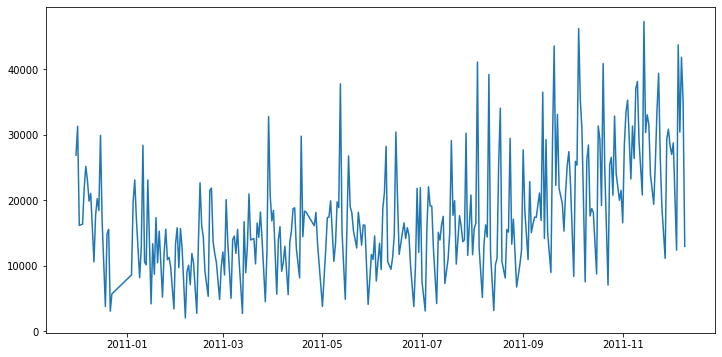

In [275]:
plt.figure(figsize=(12,6))
#gráfico da Quantidade total de itens vendidos por dia
plt.plot(total.index, total['Quantidade']);

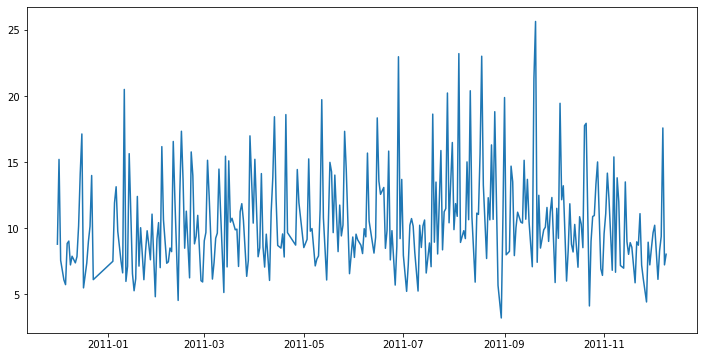

In [276]:
plt.figure(figsize=(12,6))
#gráfico da Quantidade Média de itens vendidos por dia
plt.plot(total.index, total['Quantidade_Media']);

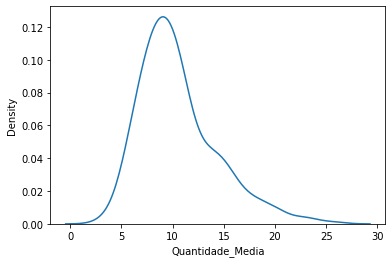

In [277]:
sns.kdeplot(x=total['Quantidade_Media']);

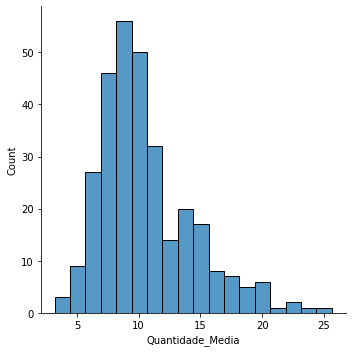

In [278]:
sns.displot(x=total['Quantidade_Media']);

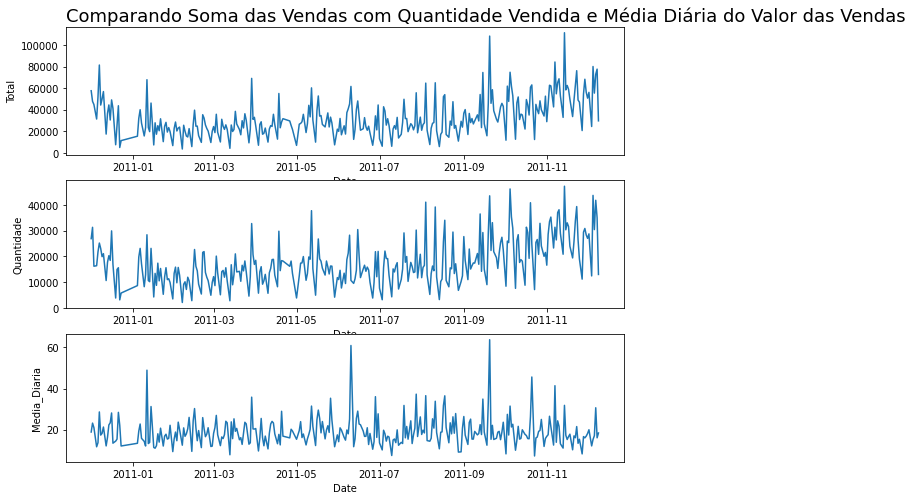

In [279]:
plot_comparacao('Date', 'Total', 'Quantidade', 'Media_Diaria', total, 'Comparando Soma das Vendas com Quantidade Vendida e Média Diária do Valor das Vendas')

In [285]:
#Correlação entre Valor Total e Quantidade Vendida
corr = total[['Total','Quantidade','Media_Diaria','Quantidade_Media']].corr()
corr

,Total,Quantidade,Media_Diaria,Quantidade_Media
Total,1.000000,0.927247,0.590731,0.421634
Quantidade,0.927247,1.000000,0.512562,0.546891
Media_Diaria,0.590731,0.512562,1.000000,0.830086
Quantidade_Media,0.421634,0.546891,0.830086,1.000000


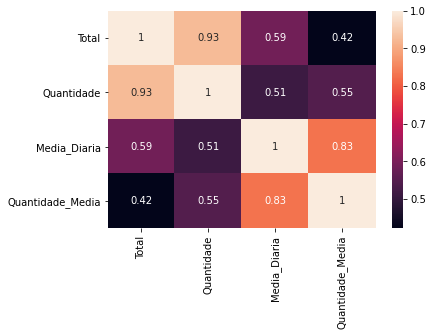

In [286]:
sns.heatmap(corr, annot=True);

In [287]:
#criando um histograma para todos os dados do dataset
total.head(1)

,Total,Aumento,Aceleração,Media_Diaria,Quantidade,Quantidade_Media
Date,,,,,,
2010-12-01,57626.33,NaN,NaN,18.807549,26909,8.782311


In [288]:
#criando um dataset resumo
resumo_vendas = total.drop(['Aumento','Aceleração'],axis=1) 

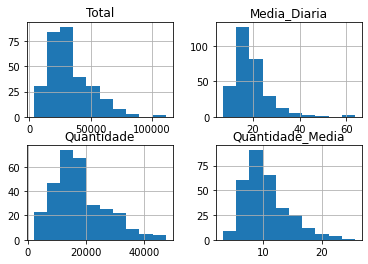

In [292]:
#criando um histograma para todos os dados do dataset
resumo_vendas.hist();

## Decomposição dos dados

In [301]:
from statsmodels.tsa.seasonal import seasonal_decompose
#decompondo os dados do total em tendência, sazonalidade e ruído
result_c = seasonal_decompose(resumo_vendas['Total'],period=35)

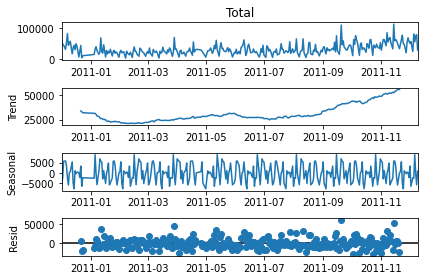

In [303]:
result_c.plot();

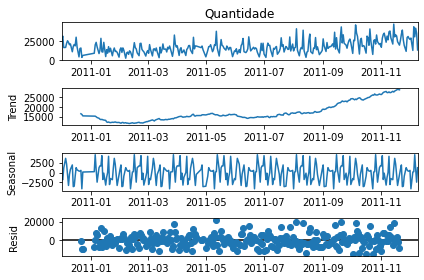

In [304]:
#decompondo os dados de Quantidade em tendência, sazonalidade e ruído
result_q = seasonal_decompose(resumo_vendas['Quantidade'],period=35)
result_q.plot();

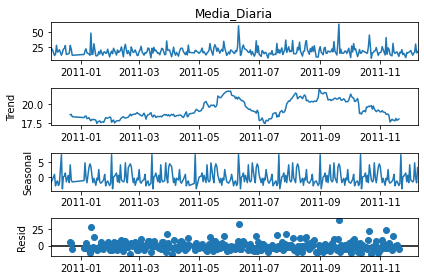

In [305]:
#decompondo os dados de Valor Médio em tendência, sazonalidade e ruído
result_m = seasonal_decompose(resumo_vendas['Media_Diaria'],period=35)
result_m.plot();

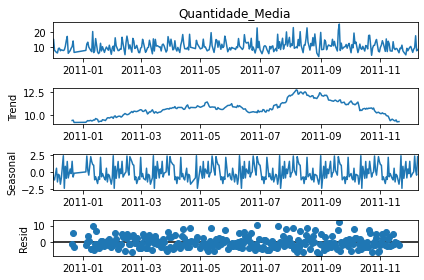

In [307]:
#decompondo os dados de Quantidade Média em tendência, sazonalidade e ruído
result_qm = seasonal_decompose(resumo_vendas['Quantidade_Media'],period=35)
result_qm.plot();

### Mudando o Período

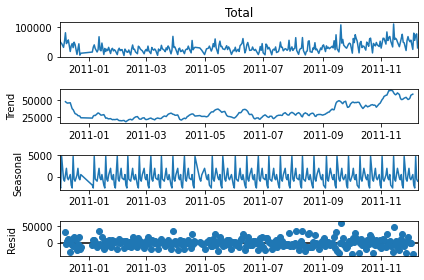

In [308]:
#decompondo os dados do total em tendência, sazonalidade e ruído
result_c = seasonal_decompose(resumo_vendas['Total'],period=10)
result_c.plot();

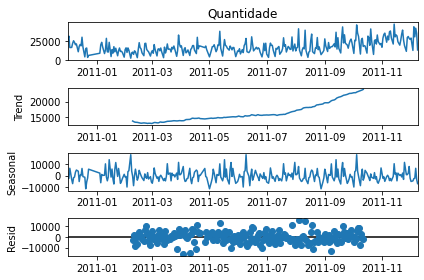

In [309]:
#decompondo os dados de Quantidade em tendência, sazonalidade e ruído
result_q = seasonal_decompose(resumo_vendas['Quantidade'],period=100)
result_q.plot();

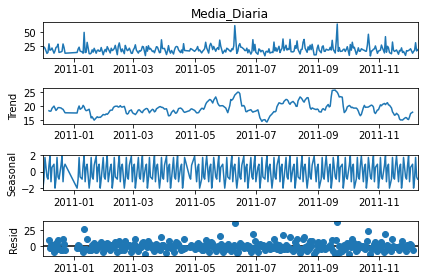

In [310]:
#decompondo os dados de Valor Médio em tendência, sazonalidade e ruído
result_m = seasonal_decompose(resumo_vendas['Media_Diaria'],period=10)
result_m.plot();

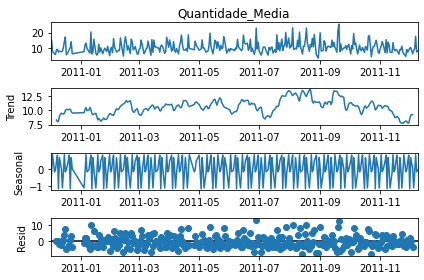

In [311]:
#decompondo os dados de Quantidade Média em tendência, sazonalidade e ruído
result_qm = seasonal_decompose(resumo_vendas['Quantidade_Media'],period=10)
result_qm.plot();

## Testando Estacionariedade

### Da Média Diária

In [314]:
#outra maneira de verificar estacionariedade
divide = int(len(resumo_vendas)/2)

In [332]:
#cria um vetor com os valores das médias diárias
x = resumo_vendas['Media_Diaria'].values

In [333]:
#dividindo em dois vetores
#usando desempacotamento de tuplas
c1, c2 = x[0:divide], x[divide:]

In [334]:
#calculando a média da primeira metade
#uma variação entre as duas médias indica a não estacionariedade dos dados
c1.mean(),c2.mean()

(18.970155471248404, 19.437252947083262)

In [335]:
#calculando a variância
#uma grande variação entre as duas variância indica a não estacionariedade dos dados
c1.var(), c2.var()

(46.276675750908204, 59.421045728640415)

In [336]:
#calculando o desvio padrão
c1.std(), c2.std()

(6.802696211863955, 7.708504766077557)

o cálculo apresenta uma diferença, mas pelo grau, não podemos afirmar que não é estacionário

### Do Valor Total diário

In [327]:
#cria um vetor com os valores das médias diárias
x = resumo_vendas['Total'].values

In [328]:
#dividindo em dois vetores
#usando desempacotamento de tuplas
c1, c2 = x[0:divide], x[divide:]

In [329]:
#calculando a média da primeira metade
#uma variação entre as duas médias indica a não estacionariedade dos dados
c1.mean(),c2.mean()

(27371.264414473742, 38340.08811764708)

In [330]:
#calculando a variância
#uma grande variação entre as duas variância indica a não estacionariedade dos dados
c1.var(), c2.var()

(184900527.16620946, 379374328.5939333)

In [331]:
#desvio padrão
c1.std(), c2.std()

(13597.813322965185, 19477.533945392915)

O valor total não é estacionário

### Quantidade

In [321]:
#cria um vetor com os valores das médias diárias
x = resumo_vendas['Quantidade'].values

In [322]:
#dividindo em dois vetores
#usando desempacotamento de tuplas
c1, c2 = x[0:divide], x[divide:]

In [323]:
#calculando a média da primeira metade
#uma variação entre as duas médias indica a não estacionariedade dos dados
c1.mean(),c2.mean()

(14421.58552631579, 21110.098039215685)

In [325]:
#calculando a variância
#uma grande variação entre as duas variância indica a não estacionariedade dos dados
c1.var(), c2.var()

(41286130.15057999, 95525670.25836216)

In [326]:
#desvio padrão
c1.std(), c2.std()

(6425.428402105184, 9773.72345927396)

Os dados de quantidade não são estacionários

#**Previsões - sobre o Total Diário**

## Previsões por Suavização Exponencial

In [338]:
#criar o dataset apenas com o valor total - que será usado para as previsões
vendas_diarias = pd.DataFrame(resumo_vendas['Total'])
vendas_diarias

,Total
Date,
2010-12-01,57626.33
2010-12-02,47715.38
2010-12-03,44833.98
2010-12-05,31318.99
2010-12-06,51873.43
...,...
2011-12-05,80132.35
2011-12-06,55411.69
2011-12-07,72922.70


In [341]:
treino = 275 #dias para treino
teste = 30 #dias para teste


In [342]:
#usando o passado como treino
treino_vendas = vendas_diarias[0:275]
teste_vendas  = vendas_diarias[275:]

In [346]:
treino_vendas[:5]

,Total
Date,
2010-12-01,57626.33
2010-12-02,47715.38
2010-12-03,44833.98
2010-12-05,31318.99
2010-12-06,51873.43


In [345]:
teste_vendas[:5]

,Total
Date,
2011-11-06,42586.60
2011-11-07,84326.52
2011-11-08,54761.14
2011-11-09,65112.73
2011-11-10,68733.78


In [347]:
#usaremos a função SimpleExpSmoothing() do statsmodels
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
#ajustando o modelo ao teste
modelo_ajustado = SimpleExpSmoothing(treino_vendas).fit(smoothing_level=0.5) #definindo o nível de suavização

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [348]:
#fazendo a previsão
#conferindo quantos pontos nós devemos prever
teste_vendas.shape
#previsão
modelo_previsto = modelo_ajustado.forecast(teste_vendas.shape[0])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


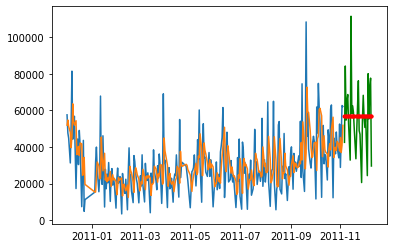

In [351]:
#plotando os dados
plt.plot(treino_vendas)
plt.plot(treino_vendas.index, modelo_ajustado.fittedvalues.values)
plt.plot(teste_vendas, 'g')
plt.plot(teste_vendas.index, modelo_previsto, 'r.'); #prevendo como pontos em vermelho
#não foi muito bom


## HoltWinters

### Os modelos consideram Nível, Tendência, Sazonalidade e Ruído:


**Modelo Aditivo**

$Y_t = N + T + S + R$

**Modelo Multiplicativo**

$Y_t = N * T * S * R$

### **Método de Holt:** Considera apenas a Tendência (nível e tendência)

*Tendência Aditiva*

$E_{t+k} = N_t + kT_t$

*Atualização do nível*

$N_t = {\alpha}Y_t + ( 1 - {\alpha})*(N_{t-1} + T_{t-1}1) $

*Atualização da tendência*

$T_t = {\beta}(N_t - N_{t-1}) + ( 1 - {\beta})* T_{t-1} $

*Tendência Multiplicativa*

$E_{t+k} = N_t (T_t)^k$

### **Método de Holt-Winters:** Considera também a sazonalidade

*Modelo Aditiva*

$E_{t+k} = N_t + kT_t + S_{t+k-M}$

*Modelo multiplicativo com tendência aditiva*

$E_{t+k} = (N_t + kT_t)S_{t+k-M}$

*Sazonalidade*

$S_t = {\gamma} \frac{Y_t}{L_t} + ( 1 - {\gamma})S_{t-M}$

In [352]:
#importando o objeto
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [353]:
#função ExponencialSmoothing do pacote statsmodels
modelo_ajustado = ExponentialSmoothing(treino_vendas.values, trend='additive', 
                     seasonal='additive', seasonal_periods=35).fit() #informa os dados, tendência, sazonalidade e períodos

In [355]:
#fazendo previsões
treino_vendas.shape[0], vendas_diarias.shape[0]

(275, 305)

In [358]:
#prevendo os dados de teste (por isso chamamos o shape)
modelo_previsto = modelo_ajustado.predict(start=276, end = 305)

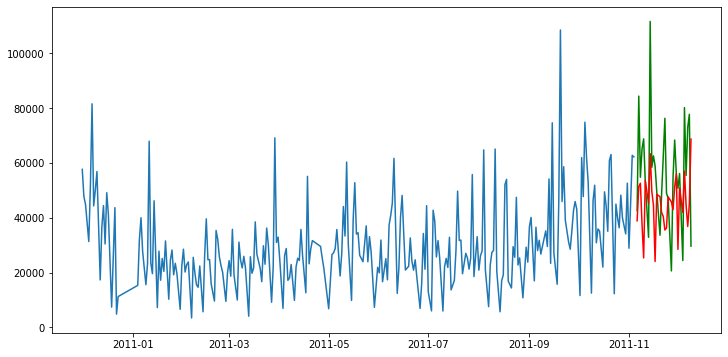

In [360]:
#plotando os dados
plt.figure(figsize=(12,6))
plt.plot(treino_vendas)
plt.plot(teste_vendas, 'g') #linha verde
plt.plot(teste_vendas.index, modelo_previsto, 'r')#linha vermelha
plt.show()

#**Autocorrelação**

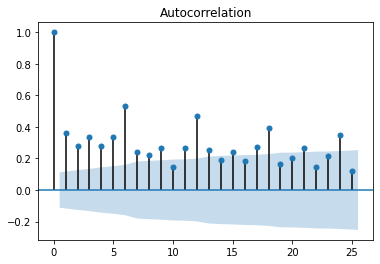

In [361]:
from statsmodels.graphics.tsaplots import plot_acf
#usando a função do statsmodels para autocorrelação. 
#alta sazonalidade se reflete em valores altos
#o cone azul define o intervalo de confiança
plot_acf(vendas_diarias);

### Autocorrelação Parcial

In [362]:
#para sazonalidade de dados a gente espera pelo menos dois valores altos no início do gráfico
from statsmodels.graphics.tsaplots import plot_pacf

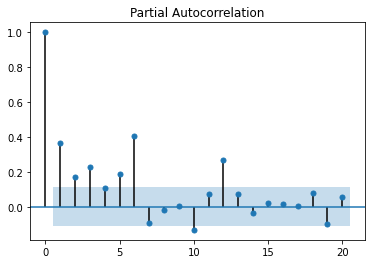

In [366]:
#os dois valores altos representam a sazonalidade dos nossos dados
plot_pacf(vendas_diarias, lags=20);

## Testando a AutoRegressão

In [388]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

In [395]:
#criando uma lista de um a 40 de um em um
lista = np.linspace(1,40,40)

In [405]:
#usando a função AutoReg do statsmodels
modelo_ajustado = AutoReg(treino_vendas.values, lags = lista, trend='c', seasonal = False, period=35).fit()

In [406]:
previsto = modelo_ajustado.predict(start=276, end=305)

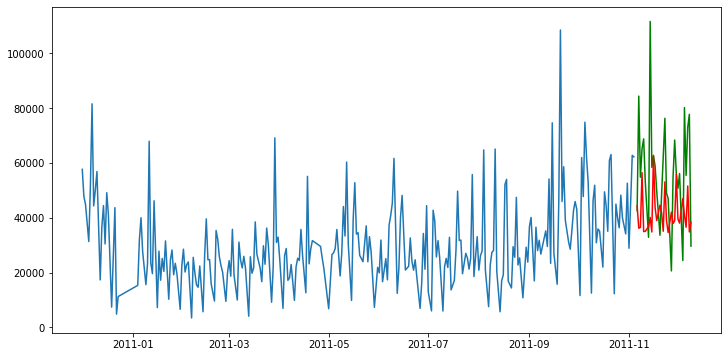

In [407]:
#gerando a imagem
plt.figure(figsize=(12,6))
plt.plot(treino_vendas)
plt.plot(teste_vendas, 'g')
plt.plot(teste_vendas.index, previsto[1:], 'r')
plt.show()